In [1]:
num_weeks = 15

## VENTAS

In [2]:
import xmlrpc.client
from datetime import date, timedelta, datetime
import pandas as pd

# Conexión con Odoo (manteniendo tus credenciales)
username = "juan.cano@donsson.com"  # tu usuario
password = "1000285668"         # tu contraseña
url = "https://donsson.com"     # URL del servidor
db = "Donsson_produccion" # nombre de la base de datos


# --- Autenticación ---
common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")

# --- Fechas ---
weeks = num_weeks

# --- Fechas automáticas ---
hoy = date.today()
fecha_fin = hoy.strftime("%Y-%m-%d")
fecha_inicio = (hoy - timedelta(weeks=weeks)).strftime("%Y-%m-%d")

# --- 1) Buscar facturas válidas (account.invoice) ---

invoice_domain = [
    ("date_invoice", ">=", fecha_inicio),
    ("date_invoice", "<=", fecha_fin),
    ("type", "=", "out_invoice"),    # solo ventas
    ("state", "in", ["open", "paid"])
]

invoice_ids = models.execute_kw(
    db, uid, password,
    "account.invoice", "search",
    [invoice_domain]
)
print(f"Facturas encontradas: {len(invoice_ids)}")

# --- 2) Descargar las líneas de esas facturas (account.invoice.line) ---

# Campos de la LÍNEA de factura. Eliminamos 'number', 'user_id', 'section_id', 'partner_id' porque irán en la factura.
line_fields = ["product_id", "quantity", "price_subtotal", "invoice_id","create_date","origin"] 

records = []
limit = 20000
offset = 0

while True:
    result = models.execute_kw(
        db, uid, password,
        "account.invoice.line", "search_read",
        [[("invoice_id", "in", invoice_ids)]],
        {"fields": line_fields, "limit": limit, "offset": offset}
    )
    if not result:
        break
    records.extend(result)
    offset += limit
    print(f"Descargados {len(records)} registros de líneas...")

# --- 3) Pasar a DataFrame de líneas ---
line_df = pd.DataFrame(records).fillna(0)


# Separar product_id
line_df["product_id_num"] = line_df["product_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["product_name"] = line_df["product_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar invoice_id
line_df["invoice_id_num"] = line_df["invoice_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["invoice_name"] = line_df["invoice_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Convertir fecha a datetime
line_df["date_invoice"] = pd.to_datetime(line_df["create_date"], errors="coerce")

# Eliminar las columnas originales problemáticas
line_df = line_df.drop(columns=["product_id", "invoice_id","create_date"])

print(f"Total de líneas descargadas: {len(line_df)}")

# ----------------------------------------------------
# --- 4) Descargar los campos adicionales de Factura (account.invoice) ---
# ----------------------------------------------------
# Añadimos los campos que quieres: number, user_id, section_id, y también partner_id y store_id
invoice_fields = ["id", "store_id", "number", "user_id", "section_id", "partner_id"]
invoices = models.execute_kw(
    db, uid, password,
    "account.invoice", "read",
    [invoice_ids], # Solo las facturas que encontramos
    {"fields": invoice_fields}
)
invoice_df = pd.DataFrame(invoices)

# --- 5) Procesar campos de la factura ---

# Separar store_id
invoice_df["store_name"] = invoice_df["store_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar user_id (Vendedor)
invoice_df["salesperson_name"] = invoice_df["user_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar section_id (Equipo de Ventas)
invoice_df["sales_team_name"] = invoice_df["section_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar partner_id (Cliente/Partner)
invoice_df["partner_id_num"] = invoice_df["partner_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
# El nombre del partner es el segundo elemento de la tupla (si existe)
invoice_df["client_name_inv"] = invoice_df["partner_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)


# Eliminar columnas originales no deseadas o ya procesadas
invoice_df = invoice_df.drop(columns=["store_id", "user_id", "section_id", "partner_id"])


# ----------------------------------------------------
# --- 6) Fusionar DataFrames ---
# ----------------------------------------------------

# Fusionamos las líneas de factura (line_df) con los datos de las facturas (invoice_df)
df = line_df.merge(
    invoice_df, 
    left_on="invoice_id_num", 
    right_on="id", 
    how="left"
)

# Limpieza final de columnas de IDs de factura
df = df.drop(columns=["invoice_id_num", "product_id_num"])


df['origin'] = df['origin'].astype('string')

# 2 minutos 15 semanas

Facturas encontradas: 15686
Descargados 20000 registros de líneas...
Descargados 40000 registros de líneas...
Descargados 60000 registros de líneas...
Descargados 61131 registros de líneas...
Total de líneas descargadas: 61131


In [3]:
df["quantity"].describe()

count    61131.000000
mean         3.317891
std         14.245764
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       2410.000000
Name: quantity, dtype: float64

## VENTAS PERDIDAS

In [4]:
import xmlrpc.client
from datetime import date, timedelta
import pandas as pd

# ===============================
# 1. Conexión con Odoo
# ===============================

ODOO_URL = "https://donsson.com"
ODOO_DB = "Donsson_produccion"
ODOO_USERNAME = "juan.cano@donsson.com"
ODOO_PASSWORD = "1000285668"

# Autenticación
common = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/common")
uid = common.authenticate(ODOO_DB, ODOO_USERNAME, ODOO_PASSWORD, {})
if not uid:
    print("Error de autenticación. Verifica tus credenciales.")
    exit()
models = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/object")

# ===============================
# 2. Definir rango de semanas
# ===============================

# Número de semanas que quieres descargar (puedes cambiarlo)
NUM_SEMANAS = num_weeks

# Fecha de hoy
hoy = date.today()
# Fecha de inicio según número de semanas atrás
fecha_inicio = hoy - timedelta(weeks=NUM_SEMANAS)

FECHA_INICIO = fecha_inicio.strftime("%Y-%m-%d")
FECHA_FIN = hoy.strftime("%Y-%m-%d")

print(f"📅 Descargando registros desde {FECHA_INICIO} hasta {FECHA_FIN}")

# ===============================
# 3. Leer ventas perdidas
# ===============================

lost_sales_ids = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "search",
    [[["fecha", ">=", FECHA_INICIO], ["fecha", "<=", FECHA_FIN], ["almacenamiento_tipo", "=", "agotado"]]]
)

lost_sales_data = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "read",
    [lost_sales_ids],
    {"fields": ["origen", "store_id", "cliente_id", "fecha", "product_ref",
                "cantidad", "cantidad_existencia", "cantidad_reservada",
                "almacenamiento_tipo"]}
)

df_vp = pd.DataFrame(lost_sales_data)

# ===============================
# 4. Normalizar columnas
# ===============================

for col in ["store_id", "cliente_id"]:
    df_vp[col.replace('_id', '_name')] = df_vp[col].apply(
        lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else str(x) if x else None
    )
    df_vp[col + "_num"] = df_vp[col].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None
    )

# Eliminar columnas originales
df_vp = df_vp.drop(columns=["id", "store_id", "cliente_id"], errors='ignore')

# ===============================
# 4.1. Forzar tipos de columnas antes de exportar
# ===============================
for col in df_vp.columns:
    if col.endswith("_num"):
        df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").astype("Int64")
    else:
        df_vp[col] = df_vp[col].astype("string")

df_vp = df_vp.copy()


📅 Descargando registros desde 2025-07-23 hasta 2025-11-05


In [5]:
df_vp[df_vp["product_ref"]=="DAB14666025"]

,cantidad_reservada,product_ref,cantidad,almacenamiento_tipo,fecha,cantidad_existencia,origen,store_name,store_id_num,cliente_name,cliente_id_num
7484,0,DAB14666025,33,agotado,2025-08-30,0,cotizacion,PRINCIPAL COTA,1,[CC932878999] DONSSON FILTERS FLORIDA LLC,37560
8136,8,DAB14666025,24,agotado,2025-09-02,21,cotizacion,SUCURSAL CALLE 6,2,[CO9008179203] WM FILTERS S.A.S.,4831
8247,29,DAB14666025,1,agotado,2025-09-02,0,cotizacion,SUCURSAL CALLE 6,2,[CC222222222221] CONSUMIDOR FINAL CALLE 6,27635
8261,0,DAB14666025,24,agotado,2025-09-02,29,pos,SUCURSAL CALLE 6,2,[CO9007734795] SPECIAL FILTERS DT S.A.S.,16506
8409,29,DAB14666025,1,agotado,2025-09-03,0,cotizacion,SUCURSAL CALLE 6,2,[CO8600568988] DOSMOPAR S.A.S.,3311
8426,29,DAB14666025,1,agotado,2025-09-03,0,cotizacion,SUCURSAL CALLE 6,2,[CO8300226123] J E FILTROS LTDA,3114
8666,29,DAB14666025,2,agotado,2025-09-03,0,cotizacion,SUCURSAL CALLE 6,2,[CC98345661] LUIS ANDER GUANCHA PANTOJA,26016


In [6]:
df_vp.sample(10)

,cantidad_reservada,product_ref,cantidad,almacenamiento_tipo,fecha,cantidad_existencia,origen,store_name,store_id_num,cliente_name,cliente_id_num
8884,0,DCS00287137,6,agotado,2025-09-04,2,cotizacion,SUCURSAL VALLADOLID,6,[CO9012688725] GRUPO VALUE S.A.S,36026
12433,0,BHE00150125,1,agotado,2025-09-19,0,cotizacion,SUCURSAL CALI,15,[CC222222222229] CONSUMIDOR FINAL CALI,37601
5500,0,DAB14671025,1,agotado,2025-08-22,0,cotizacion,PRINCIPAL COTA,1,[CO9004755272] RENTSOL SAS,28300
11529,0,DAX90181222,1,agotado,2025-09-16,0,cotizacion,SUCURSAL MEDELLIN,8,[CO8010016769] CENTRALQUIPOS S.A.S BIC,2954
8543,0,DCS00540139,20,agotado,2025-09-03,0,cotizacion,SUCURSAL BARRANQUILLA,10,[CO9013128621] LUBRICENTRO LA BENDICION S.A.S,27213
735,0,DAE02505025,2,agotado,2025-07-28,0,pos,SUCURSAL BARRANQUILLA,10,[CO9015013977] SERTECC SAS,41269
3792,0,DAE04518125,1,agotado,2025-08-13,0,cotizacion,PRINCIPAL COTA,1,[CC222222222226] CONSUMIDOR FINAL COTA,27640
2606,2,BCS00753125,1,agotado,2025-08-06,0,cotizacion,SUCURSAL CALLE 6,2,[CC52088213] ANGELICA PATRICIA RUBIANO LASSO,36515
15469,0,BHE10064125,1,agotado,2025-10-06,0,cotizacion,SUCURSAL MEDELLIN,8,"[CO80009296] PROMOCION BALDWIN48%, RACOR46% >...",13659
10746,0,DCS00758189,12,agotado,2025-09-12,11,cotizacion,SUCURSAL BUCARAMANGA,11,[CC22222222222] PROMOCION AUTPARTS >$ 1´000.00...,25223


In [34]:
df_vp.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/vp_intermillenium.xlsx")

In [7]:
import pandas as pd
import numpy as np

# ===============================
# Filtrar almacenamiento agotado
# ===============================
df_vp = df_vp[df_vp["almacenamiento_tipo"].str.lower() == "agotado"]

# ===============================
# Asegurar tipos correctos
# ===============================
df_vp = df_vp.copy()
df_vp["fecha"] = pd.to_datetime(df_vp["fecha"], errors="coerce")

# Numéricos
for col in ["cantidad", "cantidad_existencia", "cantidad_reservada"]:
    df_vp[col] = pd.to_numeric(df_vp[col], errors="coerce").fillna(0).clip(lower=0)

# ===============================
# Reglas Odoo vectorizadas
# ===============================
is_cot = df_vp["origen"].fillna("").str.lower() == "cotizacion"
ignore_mask = df_vp["cantidad"] >= 100 #percentiles evaluar

ajuste = np.where(
    is_cot,
    df_vp["cantidad"] - df_vp["cantidad_existencia"] - df_vp["cantidad_reservada"],
    df_vp["cantidad"] - df_vp["cantidad_reservada"]
)

# Aplicar reglas de descarte y piso en cero
ajuste = np.where(ignore_mask, 0, ajuste)
ajuste = np.where(ajuste > 0, ajuste, 0)

df_vp["ventas_perdidas"] = ajuste.astype(float)

# ===============================
# Columnas temporales
# ===============================
df_vp["Semana"] = df_vp["fecha"].dt.to_period("W").dt.start_time
df_vp["ano"]   = df_vp["Semana"].dt.year
df_vp["mes"]   = df_vp["Semana"].dt.month
df_vp["dia"]   = df_vp["Semana"].dt.day

# ===============================
# Filtro adicional: excluir SERV y CARCASA
# ===============================
mask_excluir = ~df_vp["product_ref"].str.contains("SERV|CARCASA", case=False, na=False)
df_vp = df_vp[mask_excluir]


df_vp.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/exceles/vp_meses/vp_def.xlsx")
# ===============================
# Agrupación por tienda + producto + semana
# ===============================
lost_by_week = (
    df_vp.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"])
    .agg(
        lost_sales=("ventas_perdidas", "sum"),   # suma total de ventas perdidas
        veces_vp=("ventas_perdidas", "count")    # número de veces que hubo pérdida
    )
    .reset_index()
)

# Mostrar resultado agrupado
vp_week = lost_by_week

In [8]:
vp_week.head()

,store_name,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
0,PRINCIPAL COTA,3LTKB400,2025-10-20,2025,10,20,15.0,1
1,PRINCIPAL COTA,AC10388020,2025-09-22,2025,9,22,36.0,4
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,2025,7,28,1.0,1
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,2025,8,11,1.0,1
4,PRINCIPAL COTA,AHBNTO68030,2025-07-28,2025,7,28,2.0,1


## COSTOS

In [9]:
import xmlrpc.client
import pandas as pd


# ===============================
# Conexión con Odoo
# ===============================
username = "juan.cano@donsson.com"   # tu usuario
password = "1000285668"              # tu contraseña
url = "https://donsson.com"          # URL del servidor
db = "Donsson_produccion"            # nombre de la base de datos

common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")


#df_campos.info()


productos_costo = models.execute_kw(
    db , uid , password,
    "cs.analisis.costo","search_read",
    [[]],
    {"fields":["producto_costo_unitario","producto_id"]}


)

# Convertir en df
df_p = pd.DataFrame(productos_costo)


# Separar lista anidada
df_p[["product_id_num","product_name"]] = (df_p["producto_id"].apply(pd.Series))

#Agregar columna estandarizada
df_p["product_name"] = df_p["product_name"].str.strip()

#DF normalizado
df_p = df_p[["product_name","producto_costo_unitario"]]

In [33]:
df_p.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/costs.xlsx")

# EDA

## Facturas

In [11]:
import re
import unicodedata



mapa_sucursales = {
    'BD1': 'PRINCIPAL COTA',
    'BD2': 'SUCURSAL CALLE 6',
    'BD3': 'SUCURSAL VALLADOLID',
    'BD4': 'SUCURSAL NORTE',
    'BD5': 'SUCURSAL MEDELLIN',
    'BD6': 'SUCURSAL BARRANQUILLA',
    'BD7':' SUCURSAL BUCARAGAMNGA ',
    'BD8':'MOSTRADOR COTA',
    'BD9':'SUCURSAL CALI',
    'BD11': 'CUMMINS DE LOS ANDES',
    'BD12': 'CUMMINS DE LOS ANDES MEDELLIN',
    'BD13': 'CSS CONSTRUCTORES',
    'BD14': 'ANTIOQUEÑA DE LUBRICANTES SGP SAS',
    'BD15': 'ASEO CAPITAL',
    'BD16': 'COVIANDES',
    'BD18': 'CEMEX BOSA',
    'BD19': 'Cemex ibague (eliminar)',
    'BD21': 'CEMEX CENTENARIO',
    'BD22': 'PENDIENTE POR FACTURAR CIERRE CONT.',
    'BD24': 'FILTRO EN REPROCESO',
    'BD26': 'PRESTAMOS INTERNOS',
    'BD31': 'EXP.CTP',
    'BD32': 'EXP. ECUADOR',
    'BD34':'EXP.DONSSON.USA',
    'BD40': 'DESCUADRE B1',
    'BD MP':'MATERIA PRIMA',
    'BD41':'BODEGA VENDEDOR WILMER GIL',
    'BD33':'EXP.REP.DOMINICANA',
    'BD42':'STOCK SIGMA ENERGY'
    # Agrega más códigos si los encuentras en tus datos, siguiendo este formato.
    }




def clasificar_sucursal(invoice_name):
    if pd.isna(invoice_name):
        return "VENDEDOR EXTERNO"
    if "Mostrador" in invoice_name:
        return "MOSTRADOR"
    return "VENDEDOR EXTERNO"
    
df["Sucursal_tipo"] = df["invoice_name"].apply(clasificar_sucursal)




#Quitar las facturas que salen como SO son no vendibles
df = df[~(df["origin"].str.contains("SO"))] 


# Normalizar los separadores para que todos sean iguales
df["origin_norm"] = df["origin"].str.replace(r"[\\/]", "/", regex=True)

# Extraer solo el BD y el número (ejemplo: BD11, BD9, etc.)
df["origen"] = df["origin_norm"].str.extract(r"^(BD\d+)")

df["Bodega"] = df["origen"].map(mapa_sucursales)
df["Bodega"] = df["Bodega"].fillna(df["store_name"])

df = df.drop(columns=["origin_norm"])


df = df.drop(columns=["origin"])

df_externos_bogota = df[(df["store_name"]=="PRINCIPAL COTA") & (df["Sucursal_tipo"]=="VENDEDOR EXTERNO")]

df = df.drop(df_externos_bogota.index)


In [12]:
df.groupby(["store_name","Bodega","Sucursal_tipo"])["quantity"].sum()

store_name             Bodega                             Sucursal_tipo   
PRINCIPAL COTA         PRINCIPAL COTA                     MOSTRADOR            4891.0
SUCURSAL BARRANQUILLA  SUCURSAL BARRANQUILLA              MOSTRADOR            7643.0
                                                          VENDEDOR EXTERNO    20204.0
SUCURSAL BUCARAMANGA    SUCURSAL BUCARAGAMNGA             VENDEDOR EXTERNO    12902.0
                       SUCURSAL BUCARAMANGA               MOSTRADOR            5968.0
SUCURSAL CALI          BODEGA VENDEDOR WILMER GIL         VENDEDOR EXTERNO      640.0
                       SUCURSAL CALI                      MOSTRADOR            1800.0
                                                          VENDEDOR EXTERNO    10134.0
SUCURSAL CALLE 6       SUCURSAL CALLE 6                   MOSTRADOR           18136.0
                                                          VENDEDOR EXTERNO     2272.0
SUCURSAL MEDELLIN      ANTIOQUEÑA DE LUBRICANTES SGP SAS  VENDEDO

In [13]:
df[df["product_name"].str.contains("DCE00833189")].sort_values(by=["quantity"],ascending=False)

,price_subtotal,id_x,quantity,product_name,invoice_name,date_invoice,number,id_y,store_name,salesperson_name,sales_team_name,partner_id_num,client_name_inv,Sucursal_tipo,origen,Bodega
32694,715000.0,1611056,50.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E43208 Mostrador Calle 6 T2/21164,2025-09-10 17:49:58,PV2E43208,436887,SUCURSAL CALLE 6,JAIME ANDRES CABALLERO CABALLERO,SUCURSALES / Ventas Mostrador Cll6,26064,[CC7334049] JAVIER SANCHEZ MONROY,MOSTRADOR,<NA>,SUCURSAL CALLE 6
3300,636000.0,1645590,40.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FCAL6025,2025-10-29 20:12:28,FCAL6025,445978,SUCURSAL CALI,JAIME ANDRES DUARTE,SUCURSALES / CALI / EXTERNOS CALI,44802,[CO9006561467] DISTRIBUIDORA INTRERNACIONAL MU...,VENDEDOR EXTERNO,BD9,SUCURSAL CALI
3166,381600.0,1645797,24.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FCL61654,2025-10-29 21:58:55,FCL61654,446031,SUCURSAL CALLE 6,EDWIN FERNANDO COLLAZOS BARRETO,SUCURSALES / Ventas Credito Cll6,29017,[CO9005104124] COMBUSTIBLES VENECIA S.A.S.,VENDEDOR EXTERNO,BD2,SUCURSAL CALLE 6
26684,286000.0,1618181,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E19894 Mostrador Valladolid T1/23194,2025-09-19 21:41:42,PV3E19894,438814,SUCURSAL VALLADOLID,JUAN DAVID SOGAMOSO,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
20606,318000.0,1625022,20.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV3E20020 Mostrador Valladolid T2/15366,2025-09-30 22:13:51,PV3E20020,440674,SUCURSAL VALLADOLID,SEBAS RODRIGUEZ,SUCURSALES / Ventas Mostrador Valladolid,17415,[CO9011799904] TODOFILTROS DEL OCCIDENTE S.A.S.,MOSTRADOR,<NA>,SUCURSAL VALLADOLID
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57290,18000.0,1581769,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,FNOR1641,2025-07-29 16:37:39,FNOR1641,429193,SUCURSAL NORTE,WILMER MULATO,SUCURSALES / Ventas Credito Norte,2939,[CO9003928975] IBJ S.A.S,VENDEDOR EXTERNO,BD4,SUCURSAL NORTE
58935,18000.0,1579917,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV2E41851 Mostrador Calle 6 T1/24654,2025-07-25 19:06:34,PV2E41851,428688,SUCURSAL CALLE 6,MAICOL MORALES RAMIREZ,SUCURSALES / Ventas Mostrador Cll6,35669,[CC11406946] JOSE ANTONIO UMAÑA HERRERA,MOSTRADOR,<NA>,SUCURSAL CALLE 6
58710,15900.0,1580171,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV1E10656 Mostrador Cota T2/3901,2025-07-26 13:51:15,PV1E10656,428782,PRINCIPAL COTA,YURI NATALIA GAONA,SUCURSALES / Ventas Mostrador Cota,28296,[CC80756999] JORGE NORBERTO AVENDAÑO QUIÑONES,MOSTRADOR,<NA>,PRINCIPAL COTA
58176,18000.0,1580769,1.0,[DCE00833189] G833 FILTRO COMBUSTIBLE CHEVROLE...,PV1E10662 Mostrador Cota T2/3912,2025-07-28 15:54:23,PV1E10662,428949,PRINCIPAL COTA,YURI NATALIA GAONA,SUCURSALES / Ventas Mostrador Cota,30566,[CO9009263462] TRANSPORTES CAMABAJA EXPRESS S....,MOSTRADOR,<NA>,PRINCIPAL COTA


In [32]:
df.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/stock_move.xlsx")

# UNION

## EMA SEMANAL CON VP SEMANALES (SOLO 2025)

In [15]:
# ===============================
# Procesar ventas normales
# ===============================
df_sales = df.copy()
df_sales["date_invoice"] = pd.to_datetime(df_sales["date_invoice"], errors="coerce")


# Referncia de producto
df_sales["product_ref"] = df_sales["product_name"].str.extract(r"\[([A-Z0-9]+)\]")


# Columnas temporales igual que en df_vp
df_sales["Semana"] = df_sales["date_invoice"].dt.to_period("W").dt.start_time
df_sales["ano"]    = df_sales["Semana"].dt.year
df_sales["mes"]    = df_sales["Semana"].dt.month
df_sales["dia"]    = df_sales["Semana"].dt.day

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
sales_by_week = (
    df_sales.groupby(["store_name", "product_ref", "Semana", "ano", "mes", "dia"], as_index=False)
    .agg(
        sales=("quantity", "sum"),              # suma de unidades vendidas
        num_facturas=("date_invoice", "nunique")  # cantidad de facturas distintas
    )
)


# Resultado
sales_by_week.sample(10)



,store_name,product_ref,Semana,ano,mes,dia,sales,num_facturas
11179,SUCURSAL BUCARAMANGA,DCE00937189,2025-10-06,2025,10,6,37.0,2
473,PRINCIPAL COTA,BCS20375125,2025-10-20,2025,10,20,2.0,1
25468,SUCURSAL NORTE,BLS00232125,2025-11-03,2025,11,3,1.0,1
16951,SUCURSAL CALLE 6,BLS00699125,2025-08-18,2025,8,18,1.0,1
12762,SUCURSAL CALI,BLS10023125,2025-09-01,2025,9,1,6.0,1
14259,SUCURSAL CALI,DCE00868189,2025-08-25,2025,8,25,1.0,1
8609,SUCURSAL BUCARAMANGA,BHE00687125,2025-07-28,2025,7,28,1.0,1
6318,SUCURSAL BARRANQUILLA,DAE09147025,2025-08-18,2025,8,18,1.0,1
12838,SUCURSAL CALI,BWS30078125,2025-08-18,2025,8,18,1.0,1
5529,SUCURSAL BARRANQUILLA,DAB08137025,2025-08-18,2025,8,18,2.0,1


In [16]:
df_merged = pd.merge(
    sales_by_week[["store_name", "product_ref", "Semana", "sales","num_facturas"]],
    vp_week[["store_name", "product_ref", "Semana", "lost_sales","veces_vp"]],
    on=["store_name", "product_ref", "Semana"],
    how="outer"
).fillna(0)


In [17]:
df_merged["año"]    = df_merged["Semana"].dt.year
df_merged["mes"]    = df_merged["Semana"].dt.month
df_merged["dia"]    = df_merged["Semana"].dt.day


df_merged.head(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
0,PRINCIPAL COTA,3LTKB400,2025-10-20,0.0,0.0,15.0,1.0,2025,10,20
1,PRINCIPAL COTA,AC10388020,2025-09-22,0.0,0.0,36.0,4.0,2025,9,22
2,PRINCIPAL COTA,AGB0GRAS030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
3,PRINCIPAL COTA,AHB80W90050,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
4,PRINCIPAL COTA,AHBNTO68030,2025-07-28,0.0,0.0,2.0,1.0,2025,7,28
5,PRINCIPAL COTA,AHBNTO68030,2025-08-11,4.0,1.0,12.0,1.0,2025,8,11
6,PRINCIPAL COTA,AHBNTO68030,2025-10-20,2.0,1.0,0.0,0.0,2025,10,20
7,PRINCIPAL COTA,AHG80W90030,2025-07-28,0.0,0.0,1.0,1.0,2025,7,28
8,PRINCIPAL COTA,AHG80W90030,2025-08-11,0.0,0.0,1.0,1.0,2025,8,11
9,PRINCIPAL COTA,AHG80W90030,2025-10-06,0.0,0.0,3.0,3.0,2025,10,6


In [18]:
df_merged.query("product_ref == 'BAE05001125'")

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia
5280,SUCURSAL BARRANQUILLA,BAE05001125,2025-09-08,1.0,1.0,0.0,0.0,2025,9,8
30228,SUCURSAL MEDELLIN,BAE05001125,2025-08-18,0.0,0.0,1.0,1.0,2025,8,18
30229,SUCURSAL MEDELLIN,BAE05001125,2025-10-13,0.0,0.0,1.0,1.0,2025,10,13


In [19]:
df_merged["product_ref"].nunique()

3359

## NORMALIZAR DF DE COSTOS

In [20]:
df_p["product_ref"] = df_p["product_name"].str.extract(r"\[([A-Z0-9]+)\]")

df_p_unique = (
    df_p[["product_ref", "producto_costo_unitario"]]
    .drop_duplicates(subset=["product_ref"])
)



df_p["product_ref"].nunique()

4860

## EMA 

In [21]:
import pandas as pd
import numpy as np

def compute_demand_and_ema(df,
                           alpha=0.20,        # peso de EMA
                           n_init=12,   # semanas o meses para inicializar EMA
                           date_col="Semana", #Semana o Mes
                           sales_col="sales",
                           lost_col="lost_sales",
                           freq ="W-MON" # "W-MON" semanas y "M" meses
                           ):
    df = df.copy()

    # ---------- Asegurar tipos y semana iniciando lunes ----------
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[date_col] = df[date_col].dt.to_period(freq).dt.start_time #W_MON para lunes en semanas M para primer dia del mes

    # Asegurar numéricos
    df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce").fillna(0)
    df[lost_col]  = pd.to_numeric(df[lost_col], errors="coerce").fillna(0)

    # ---------- Crear combinaciones completas ----------
    stores   = df["store_name"].unique()
    products = df["product_ref"].unique()


    # Crear rango completo desde min hasta max semana
    weeks = pd.period_range(df[date_col].min(), df[date_col].max(), freq=freq).to_timestamp()


    full_index = pd.MultiIndex.from_product([stores, products, weeks],
                                            names=["store_name", "product_ref", date_col])

    df = df.set_index(["store_name", "product_ref", date_col]).reindex(full_index).reset_index()

    # Rellenar ventas y perdidas con 0 en combinaciones faltantes
    df[sales_col] = df[sales_col].fillna(0)
    df[lost_col]  = df[lost_col].fillna(0)

    # Ordenar
    df = df.sort_values(["store_name", "product_ref", date_col])

    out_groups = []

    # ---------- Calcular demanda ajustada y EMA ----------
    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        sales = g[sales_col].to_numpy(dtype=float)
        lost  = g[lost_col].to_numpy(dtype=float)

        L = len(g)
        demanda = np.zeros(L, dtype=float)
        ema_arr = np.zeros(L, dtype=float)

        if L == 0:
            out_groups.append(g)
            continue

        # Inicialización EMA: promedio de primeras n_init ventas
        init_n = min(n_init, L)
        ema_prev = float(np.nanmean(sales[:init_n])) if init_n > 0 else 0.0
        if np.isnan(ema_prev):
            ema_prev = 0.0

        for i in range(L):
            s = sales[i]
            l = lost[i]

            # Regla 1
            if s >= 2.0 * l:
                demand_candidate = s + l
                demand = min(demand_candidate, 1.5 * s) if s > 0 else demand_candidate
            else:
                # Regla 2
                demand = s + 0.5 * ema_prev

            # Guardar redondeando
            demanda[i] = round(demand, 6)

            # Calcular EMA
            ema = alpha * demand + (1.0 - alpha) * ema_prev
            ema = round(ema, 6)
            ema_arr[i] = ema

            # actualizar para siguiente
            ema_prev = ema

        # Añadir columnas al grupo
        g = g.copy()
        g["demanda_ajustada"] = demanda
        g["EMA"] = ema_arr

        out_groups.append(g)

        

    # Concat resultados
    result = pd.concat(out_groups, ignore_index=True, sort=False)
    result = result.sort_values(["store_name", "product_ref", date_col]).reset_index(drop=True)
    return result

# ------------------ USO ------------------
df_with_demand1 = compute_demand_and_ema(df_merged, alpha=0.2, n_init=num_weeks) #estaba en 16

#APROX3min

In [22]:
df_filtrado_ordenado = df_with_demand1.query(
    "product_ref == 'DCE10126138' and store_name == 'SUCURSAL VALLADOLID'"
).sort_values(
    by=["Semana", "EMA"],  # Ordena primero por 'Semana', luego por 'EMA'
    ascending=[True, True] # Ambos en orden ascendente
)

df_filtrado_ordenado.tail(10)

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
423478,SUCURSAL VALLADOLID,DCE10126138,2025-08-26,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,1.415578
423479,SUCURSAL VALLADOLID,DCE10126138,2025-09-02,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,1.132462
423480,SUCURSAL VALLADOLID,DCE10126138,2025-09-09,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.905970
423481,SUCURSAL VALLADOLID,DCE10126138,2025-09-16,0.0,0.0,82.0,1.0,2025.0,9.0,22.0,0.452985,0.815373
423482,SUCURSAL VALLADOLID,DCE10126138,2025-09-23,90.0,1.0,63.0,1.0,2025.0,9.0,29.0,90.407686,18.733836
423483,SUCURSAL VALLADOLID,DCE10126138,2025-09-30,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,14.987069
423484,SUCURSAL VALLADOLID,DCE10126138,2025-10-07,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,11.989655
423485,SUCURSAL VALLADOLID,DCE10126138,2025-10-14,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,9.591724
423486,SUCURSAL VALLADOLID,DCE10126138,2025-10-21,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,7.673379
423487,SUCURSAL VALLADOLID,DCE10126138,2025-10-28,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,6.138703


In [23]:
df_with_demand1[(df_with_demand1["store_name"]=="SUCURSAL NORTE") & (df_with_demand1["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,sales,num_facturas,lost_sales,veces_vp,año,mes,dia,demanda_ajustada,EMA
357904,SUCURSAL NORTE,DAE02286025,2025-07-15,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.320000
357905,SUCURSAL NORTE,DAE02286025,2025-07-22,0.0,0.0,1.0,1.0,2025.0,7.0,28.0,0.160000,0.288000
357906,SUCURSAL NORTE,DAE02286025,2025-07-29,0.0,0.0,6.0,1.0,2025.0,8.0,4.0,0.144000,0.259200
357907,SUCURSAL NORTE,DAE02286025,2025-08-05,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.207360
357908,SUCURSAL NORTE,DAE02286025,2025-08-12,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.165888
357909,SUCURSAL NORTE,DAE02286025,2025-08-19,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.132710
357910,SUCURSAL NORTE,DAE02286025,2025-08-26,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.106168
357911,SUCURSAL NORTE,DAE02286025,2025-09-02,0.0,0.0,6.0,1.0,2025.0,9.0,8.0,0.053084,0.095551
357912,SUCURSAL NORTE,DAE02286025,2025-09-09,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.076441
357913,SUCURSAL NORTE,DAE02286025,2025-09-16,6.0,1.0,2.0,3.0,2025.0,9.0,22.0,8.000000,1.661153


In [24]:
def add_deviation_and_classification(df, ema_col="EMA", sales_col="sales", week_col="Semana", n_weeks=num_weeks): ##PERILLA SEMANAS 
    df = df.copy()
    out_groups = []

    for (store, prod), g in df.groupby(["store_name", "product_ref"], sort=False):
        g = g.sort_values(week_col).reset_index(drop=True)
        
        sales = g[sales_col].to_numpy(dtype=float)
        ema   = g[ema_col].to_numpy(dtype=float)
        L = len(sales)

        # Inicializamos columnas
        g["desviacion_ema%"] = 0.0
        g["coef_ventas"] = 0.0

        if L < 2:
            out_groups.append(g)
            continue

        for i in range(L):
            # Usar solo hasta la semana actual (i)
            window_start = max(0, i - n_weeks)       # ventana de 12 semanas
            window_sales = sales[window_start:i]     # semanas previas
            window_ema   = ema[window_start:i]

            if len(window_sales) < 2:
                continue

            promedio_prev = np.mean(window_sales)
            if promedio_prev == 0:
                promedio_prev = 1e-6

            # --- Desviación usando EMAs previos ---
            desv = np.std(window_ema, ddof=1) / promedio_prev if promedio_prev > 0 else 0

            # --- Coeficiente de ventas ---
            coef = (max(window_sales) - min(window_sales)) / promedio_prev if promedio_prev > 0 else 0

            g.at[i, "desviacion_ema%"] = round(desv,2)
            g.at[i, "coef_ventas"] = coef

        out_groups.append(g)

    return pd.concat(out_groups, ignore_index=True)





df_with_demand2 = add_deviation_and_classification(df_with_demand1)
df_with_demand2 = df_with_demand2[["store_name","product_ref","Semana","num_facturas","sales","lost_sales","demanda_ajustada","EMA","desviacion_ema%","coef_ventas"]]

# Demora mas o menos 8 min

In [25]:
df_with_demand2[(df_with_demand2["store_name"]=="SUCURSAL NORTE") & (df_with_demand2["product_ref"]=="DAE02286025")]

,store_name,product_ref,Semana,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas
357904,SUCURSAL NORTE,DAE02286025,2025-07-15,NaN,0.0,0.0,0.000000,0.320000,0.00,0.0
357905,SUCURSAL NORTE,DAE02286025,2025-07-22,0.0,0.0,1.0,0.160000,0.288000,0.00,0.0
357906,SUCURSAL NORTE,DAE02286025,2025-07-29,0.0,0.0,6.0,0.144000,0.259200,22627.42,0.0
357907,SUCURSAL NORTE,DAE02286025,2025-08-05,NaN,0.0,0.0,0.000000,0.207360,30414.03,0.0
357908,SUCURSAL NORTE,DAE02286025,2025-08-12,NaN,0.0,0.0,0.000000,0.165888,47808.69,0.0
357909,SUCURSAL NORTE,DAE02286025,2025-08-19,NaN,0.0,0.0,0.000000,0.132710,61853.44,0.0
357910,SUCURSAL NORTE,DAE02286025,2025-08-26,NaN,0.0,0.0,0.000000,0.106168,72659.62,0.0
357911,SUCURSAL NORTE,DAE02286025,2025-09-02,0.0,0.0,6.0,0.053084,0.095551,80931.95,0.0
357912,SUCURSAL NORTE,DAE02286025,2025-09-09,NaN,0.0,0.0,0.000000,0.076441,85381.10,0.0
357913,SUCURSAL NORTE,DAE02286025,2025-09-16,1.0,6.0,2.0,8.000000,1.661153,89386.09,0.0


In [26]:
df_with_demand2["semana_num"] = df_with_demand2["Semana"].dt.isocalendar().week
df_with_demand2["año"] = df_with_demand2["Semana"].dt.year


### AGREGAR SEMANA CSV

In [27]:
df_demand_2025 = df_with_demand2[df_with_demand2["año"]==2025] #Ajustar año

demand_2025 = df_demand_2025[
    ["store_name","product_ref","año","Semana","semana_num",
     "num_facturas","EMA","demanda_ajustada","desviacion_ema%","coef_ventas","lost_sales"]
]


#demand_2025_38 = demand_2025[demand_2025["semana_num"]==40]  #Ajustar semana numero

## UNIR COSTO

In [28]:
df_merge_def = pd.merge(
    demand_2025,
    df_p_unique,
    on="product_ref",
    how="outer" #para incluir todos , estaba antes left
).fillna(0)

df_merge_def.to_csv("/home/donsson/proyectos/MODELO ABASTECIMIENTO/csvsalidas/ema_mio202540.csv")

#merge_def = df_merge_def[df_merge_def["producto_costo_unitario"] !=0].copy() #Eliminar productos sin costos unitarios
merge_def =  df_merge_def.copy()
df_merge_def.sort_values(by=["EMA"],ascending=False).sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
391194,SUCURSAL BUCARAMANGA,DCS00518136,2025.0,2025-09-16 00:00:00,38,0.0,0.000000,0.0,0.00,0.000000,0.0,11438.66
228109,SUCURSAL CALLE 6,DAB08150025,2025.0,2025-10-28 00:00:00,44,0.0,0.106997,0.0,0.88,15.000000,0.0,26974.24
100519,SUCURSAL CALI,BCS00510125,2025.0,2025-08-19 00:00:00,34,0.0,0.000000,0.0,0.00,0.000000,0.0,26435.42
152961,SUCURSAL BUCARAMANGA,BHS00530125,2025.0,2025-09-30 00:00:00,40,0.0,0.272815,0.0,0.55,7.333333,0.0,108470.24
266978,SUCURSAL MEDELLIN,DAC10037020,2025.0,2025-08-05 00:00:00,32,0.0,0.000000,0.0,0.00,0.000000,0.0,9500.00
298433,PRINCIPAL COTA,DAE04520025,2025.0,2025-10-07 00:00:00,41,0.0,0.000000,0.0,0.00,0.000000,0.0,12912.04
129848,SUCURSAL BARRANQUILLA,BHE00684125,2025.0,2025-07-29 00:00:00,31,0.0,0.068267,0.0,15084.71,0.000000,0.0,81541.72
71868,SUCURSAL MEDELLIN,BCE00609125,2025.0,2025-10-28 00:00:00,44,0.0,0.999526,0.0,0.31,4.615385,0.0,40074.25
20842,SUCURSAL BUCARAMANGA,BAB09086125,2025.0,2025-09-09 00:00:00,37,0.0,0.000000,0.0,0.00,0.000000,0.0,54896.00
89350,SUCURSAL BARRANQUILLA,BCS00198125,2025.0,2025-10-07 00:00:00,41,0.0,1.360309,0.0,0.21,3.000000,0.0,38780.35


In [29]:
merge_def[merge_def["store_name"]==0].sample(10)

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
187516,0,BLS00468125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
161373,0,BLE00017125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,26847.00
256747,0,DAC00079189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
136121,0,BHE00871125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,115826.00
361687,0,DCE00446189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2375.68
274257,0,DAE01036115,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4028.50
209462,0,DAB02860025,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,6885.77
265353,0,DAC00234020,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,12500.00
256750,0,DAC00082189,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,7991.30
40200,0,BAE02672125,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,146573.28


In [30]:
merge_def.query("product_ref == 'BAE05001125'")

,store_name,product_ref,año,Semana,semana_num,num_facturas,EMA,demanda_ajustada,desviacion_ema%,coef_ventas,lost_sales,producto_costo_unitario
47000,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-15 00:00:00,29,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47001,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-22 00:00:00,30,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47002,PRINCIPAL COTA,BAE05001125,2025.0,2025-07-29 00:00:00,31,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47003,PRINCIPAL COTA,BAE05001125,2025.0,2025-08-05 00:00:00,32,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47004,PRINCIPAL COTA,BAE05001125,2025.0,2025-08-12 00:00:00,33,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
...,...,...,...,...,...,...,...,...,...,...,...,...
47123,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-09-30 00:00:00,40,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47124,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-07 00:00:00,41,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47125,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-14 00:00:00,42,0.0,0.0,0.0,0.0,0.0,0.0,90836.27
47126,SUCURSAL VALLADOLID,BAE05001125,2025.0,2025-10-21 00:00:00,43,0.0,0.0,0.0,0.0,0.0,0.0,90836.27


<Axes: >

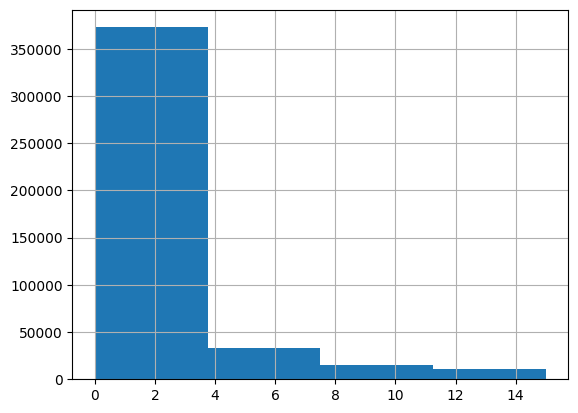

In [31]:
merge_def["coef_ventas"].hist(bins=4)